In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from tabulate import tabulate

from collections import Counter
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kingp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Collecting and cleaning data sets

In [2]:
sms_data, email_data = [], []
sms_count, email_count = 0, 0

# SMS DATASETS

# https://www.kaggle.com/datasets/galactus007/sms-smishing-collection-data-set/
df = pd.read_csv("sms_messaging.csv")
df = df.loc[df["label"] == 1]

sms_count += len(df)
sms_data = np.concatenate((sms_data, np.array(df["sms"])), axis=0)

# https://data.mendeley.com/datasets/f45bkkt8pr/1
df = pd.read_csv("sms_phishing.csv")
df = df.loc[df["LABEL"] == "Smishing"]

sms_count += len(df)
sms_data = np.concatenate((sms_data, np.array(df["TEXT"])), axis=0)

print(sms_count)


# EMAIL DATASETS

# https://www.kaggle.com/datasets/subhajournal/phishingemails
df = pd.read_csv("Phishing_Email.csv")
df = df.loc[df["Email Type"] == "Phishing Email"]

email_count += len(df)
email_data = np.concatenate((email_data, (np.array(df["Email Text"]))), axis=0)

print(email_count)

1363
7328


In [4]:
def clean_text(text):
    text = str(text)
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    
    return text

clean_sms = [clean_text(text) for text in sms_data]
clean_email = [clean_text(text) for text in email_data]

## Tables and Graphs

In [5]:
def create_sector_table(sector_counts):
    table = tabulate(sector_counts.items(), headers=['Sector', 'Count'], tablefmt="fancy_grid", numalign="center")
    print(table)

def visualize_sector_counts(labels, data):
    counts = Counter(labels)

    # Increase the figure size
    fig, ax = plt.subplots(figsize=(10, 8))

    bars = ax.bar(counts.keys(), counts.values())

    # Add labels to the bars with adjusted font size
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=12)

    ax.set_xlabel('Sectors', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    if data == 0:
        ax.set_title('Phishing SMS Counts by Sector', fontsize=16)
    else:
        ax.set_title('Phishing Email Counts by Sector', fontsize=16)

    # Explicitly set rotation angle for x-axis labels
    plt.xticks(rotation=90)

    plt.show()

## Keyword search to assign attacks to sectors

In [6]:
#Function for counting how many datapoints fall into a sector
def keyword_search(sector, keywords, data):
    count = 0
    emails, labels = [], []

    pattern = "|".join(map(re.escape, keywords))
    pattern = r"\b({})\b".format(pattern)

    for index, email in enumerate(data, start=1):
        matches = re.findall(pattern, email)

        if matches:
            emails.append(email)
            labels.append(sector)
            count += 1

    return count, emails, labels

#function for counting how many sectors an email falls into
def sectors_per(all_keys, email):
    sect_count = 0
    sectors = []
    
    for sector, keywords in all_keys.items():
        pattern = "|".join(map(re.escape, keywords))
        pattern = r"\b({})\b".format(pattern)
        matches = re.findall(pattern, email)
        if matches:
            sectors.append(sector)
    sectors = np.unique(sectors)
    count = len(sectors)
    return count, sectors

## Run search on datasets

╒════════════════╤═════════╕
│ Sector         │  Count  │
╞════════════════╪═════════╡
│ finance        │   80    │
├────────────────┼─────────┤
│ business       │   57    │
├────────────────┼─────────┤
│ medical        │    0    │
├────────────────┼─────────┤
│ technology     │   36    │
├────────────────┼─────────┤
│ free_stuff     │   670   │
├────────────────┼─────────┤
│ ringtones      │   73    │
├────────────────┼─────────┤
│ online service │   96    │
├────────────────┼─────────┤
│ 'dating'       │   141   │
╘════════════════╧═════════╛


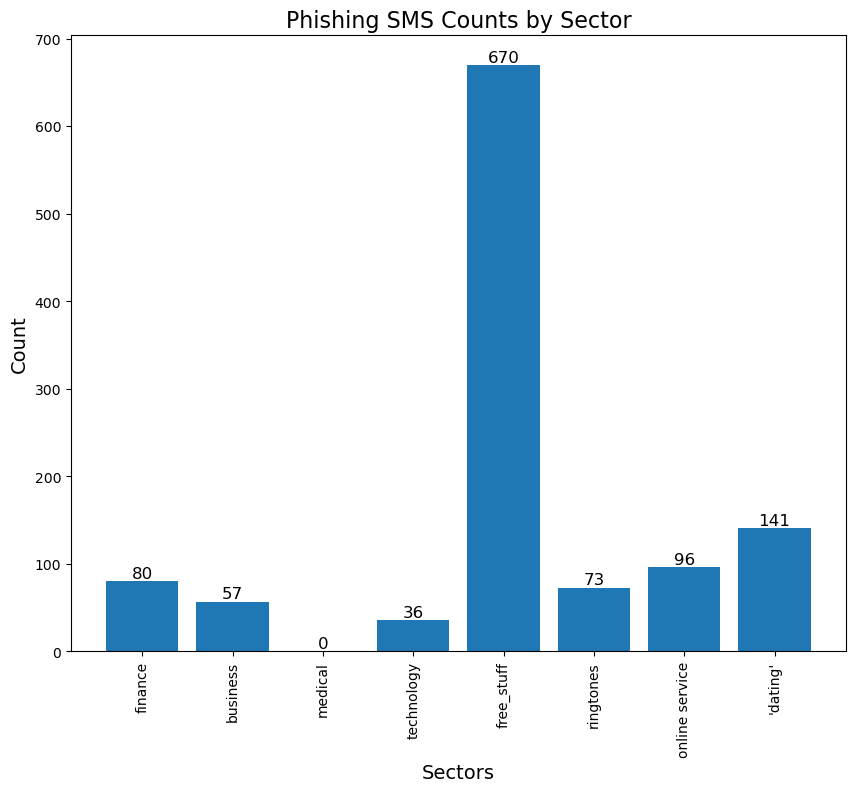

Number of Sector Labels Per SMS
   # of Labels  Count
0            1    751
1            0    416
2            2    188
3            4      2
4            3      6
╒════════════════╤═════════╕
│ Sector         │  Count  │
╞════════════════╪═════════╡
│ finance        │  1604   │
├────────────────┼─────────┤
│ business       │  2492   │
├────────────────┼─────────┤
│ medical        │   870   │
├────────────────┼─────────┤
│ technology     │  2284   │
├────────────────┼─────────┤
│ free_stuff     │  2352   │
├────────────────┼─────────┤
│ ringtones      │   19    │
├────────────────┼─────────┤
│ online service │  1995   │
├────────────────┼─────────┤
│ 'dating'       │  1502   │
╘════════════════╧═════════╛


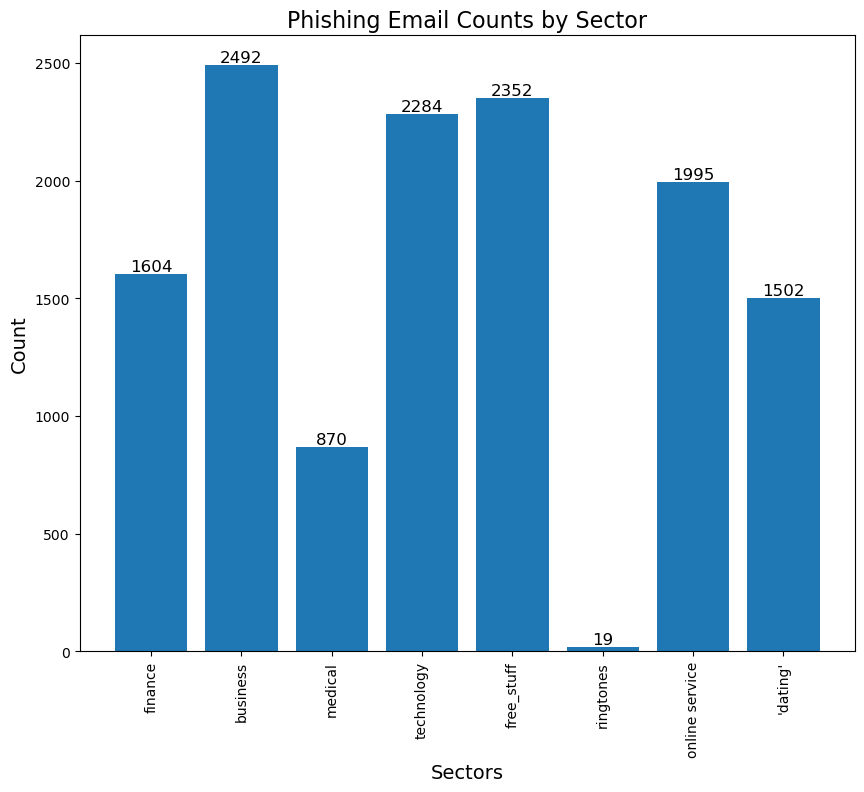


Number of Sector Labels Per Email
   # of Labels  Count
2            1   1820
4            0   1794
0            2   1578
3            3   1075
1            4    571
6            5    320
5            6    157
7            7     13


In [7]:
all_keywords_1 = {
        "finance": ["banking", "bank", "loan", "mortgage", "transaction", "deposit", "financial", "fraud", "fraudulent", "account", "finance", "debt", "purchase"],
        "business": ["business", "career", "job", "company", "stockholder", "income", "companies", "professional", "advertisement", "advertise", "marketing", "customer service"],
        "medical": ["medical", "pharmaceutical", "hospital", "hospitals", "treatment", "immune", "disease", "diseases", "medicine", "prescription", "prescriptions", "health", "drugs"],
        "technology": ["tech", "technology", "software", "hardware", "digital", "online", "cybersecurity", "hack", "data privacy", "internet", "device", "game"],
        "free_stuff": ["winner", "won", "win", "prize", "claim", "free", "receive", "awarded"],
        "ringtones": ["ringtone", "ringtones", "tones", "tone"],
        "online service": ["subscription", "online shopping", "free trial", "order confirmation", "discounts", "discount", "gift card", "shopping", "sale", "discount", "offer", "deal", "buy", "online store"],
        "'dating'": ["date", "hot", "horny", "sexy", "fun", "xxx", "flirt", "flirting", "dating", "fancy", "admirer", "sex", "dogging", "porn", "penis", "viagra", "vagra", "laid", "lover", "hardcore"],
    }

# SMS
#iterate through sectors and keep count of how many messages are in each one
sector_counts = {}
sms_total = 0
for sector, keywords in all_keywords_1.items():
    count, _, _ = keyword_search(sector, keywords, clean_sms)
    sms_total += count
    sector_counts[sector] = count
#iterate through messages and keep count of how many labels each message gets
text_labels = []
t_label_counts = []
for index, message in enumerate(clean_sms, start=1):
    t_count, labels = sectors_per(all_keywords_1, message)
    text_labels.append(labels)
    t_label_counts.append(t_count)
#print graphs for SMS results
create_sector_table(sector_counts)
visualize_sector_counts(sector_counts, 0)
#print list of label counts
s = Counter(t_label_counts)
df = pd.DataFrame(list(s.items()), columns=['# of Labels', 'Count'])
print("Number of Sector Labels Per SMS")
print(df)

# EMAIL
#iterate through sectors and keep count of how many emails are in each one
sector_counts = {}
for sector, keywords in all_keywords_1.items():
    count, _, _ = keyword_search(sector, keywords, clean_email)
    sector_counts[sector] = count
#iterate through emails and keep count of how many labels each message gets
email_labels = []
e_label_counts = []
for index, message in enumerate(clean_email, start=1):
    t_count, labels = sectors_per(all_keywords_1, message)
    email_labels.append(labels)
    e_label_counts.append(t_count)
#print graphs for email results
create_sector_table(sector_counts)
visualize_sector_counts(sector_counts, 1)
#print list of label counts
e = Counter(e_label_counts)
df = pd.DataFrame(list(e.items()), columns=['# of Labels', 'Count'])
df = df.sort_values(by='Count', ascending=False)
print("\nNumber of Sector Labels Per Email")
print(df)

## Keyword List

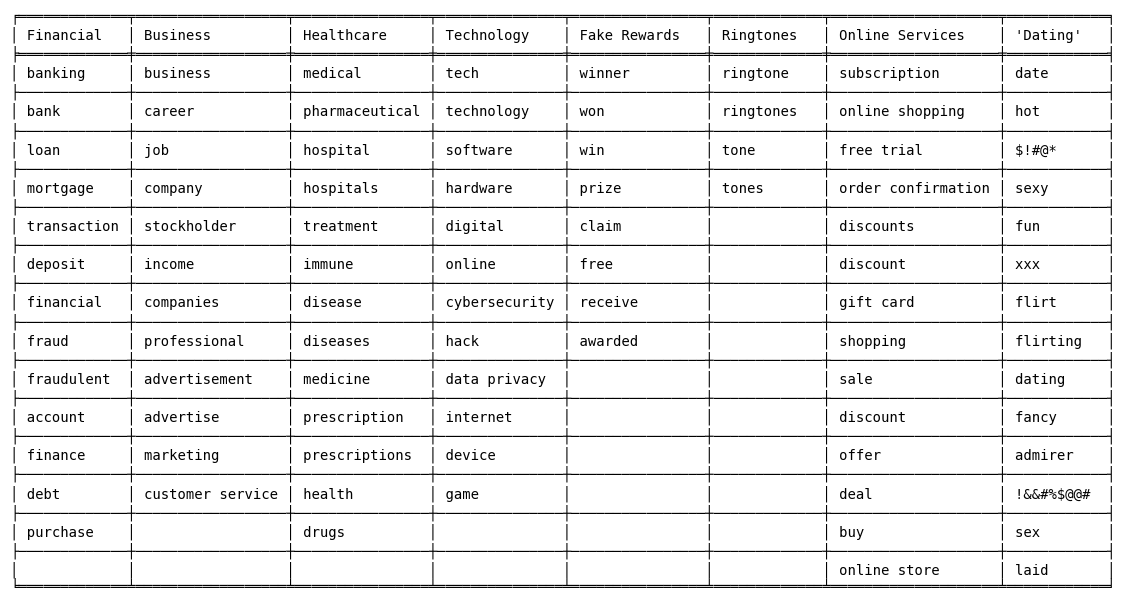

In [8]:
#Create table of sector titles and keywords for each
from tabulate import tabulate
all_keywords = {
        "finance": ["banking", "bank", "loan", "mortgage", "transaction", "deposit", "financial", "fraud", "fraudulent", "account", "finance", "debt", "purchase"],
        "business": ["business", "career", "job", "company", "stockholder", "income", "companies", "professional", "advertisement", "advertise", "marketing", "customer service"],
        "medical": ["medical", "pharmaceutical", "hospital", "hospitals", "treatment", "immune", "disease", "diseases", "medicine", "prescription", "prescriptions", "health", "drugs"],
        "technology": ["tech", "technology", "software", "hardware", "digital", "online", "cybersecurity", "hack", "data privacy", "internet", "device", "game"],
        "free_stuff": ["winner", "won", "win", "prize", "claim", "free", "receive", "awarded"],
        "ringtones": ["ringtone", "ringtones", "tone", "tones"],
        "online service": ["subscription", "online shopping", "free trial", "order confirmation", "discounts", "discount", "gift card", "shopping", "sale", "discount", "offer", "deal", "buy", "online store"],
        "'dating'": ["date", "hot", "$!#@*", "sexy", "fun", "xxx", "flirt", "flirting", "dating", "fancy", "admirer", "!&&#%$@@#", "sex", "laid"],
    }
max_len = 14
for sector, keywords in all_keywords.items():
    keywords += [''] * (max_len - len(keywords))
col_labels = ["Financial", "Business", "Healthcare", "Technology", "Fake Rewards", "Ringtones", "Online Services", "'Dating'"]
table = tabulate(all_keywords, headers=col_labels, tablefmt="fancy_grid", numalign="center")
fig, ax = plt.subplots()

ax.axis("off")
ax.annotate(table, xy=(0, 0), fontsize=10, family="monospace")

plt.show()